# PROJECT TITLE

# Business Understanding

# Data Understanding

# Data Preparation

Let's start by importing modules necessary for analysis and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Let's convert the sentences contained in the `tweet_text` column to type `string` for later analysis.

In [3]:
df['tweet_text'] = df['tweet_text'].astype(str)

Let's also rename the columns so that they are more readable.

In [4]:
df.rename(columns={"emotion_in_tweet_is_directed_at": "product", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"},inplace=True)

In [5]:
df["product"].fillna("none", inplace = True)
df_none = df.loc[df["product"] == 'none']

apple_condition = (df['product'] == "iPad") | (df['product'] == "iPad or iPhone App") | (df['product'] == "iPhone") | (df['product'] == "Other Apple product or service")
google_condition = (df['product'] == "Other Google product or service") | (df['product'] == "Android App") | (df['product'] == "Android") 
df.loc[apple_condition,'product'] = "Apple"
df.loc[google_condition, 'product'] = "Google"

# apple loop
for word in ["Apple","iphone","apple","ipad","ipad2","iPad 2","iPhone","iPad"]:
    temp_df = df_none[df_none['tweet_text'].str.contains(word)]
    temp_df['product'].replace({'none': 'Apple'}, inplace=True)
    df_none = temp_df.combine_first(df_none)
# google loop
for word in ["Google","google","Android","android"]:
    temp_df = df_none[df_none['tweet_text'].str.contains(word)]
    temp_df['product'].replace({'none': 'Google'}, inplace=True)
    df_none = temp_df.combine_first(df_none)
df_1 = df_none.combine_first(df)
# android loop
# for word in ["Android","android"]:
#     temp_df = df_none[df_none['tweet_text'].str.contains(word)]
#     temp_df['product'].replace({'none': 'Android'}, inplace=True)
#     df_none = temp_df.combine_first(df_none)

In [6]:
df_1 = df_1[df_1['product'] != "none"]

In [7]:
df_1 = df_1[df_1['emotion'] != "I can't tell"]
#df_1 = df_1[(df_1['product'] == 'Google') & (df_1['emotion'] == 'Positive emotion')]

In [8]:
df_1["emotion"].value_counts()

No emotion toward brand or product    4599
Positive emotion                      2962
Negative emotion                       569
Name: emotion, dtype: int64

In [9]:
df_1["product"].value_counts()

Apple     5384
Google    2746
Name: product, dtype: int64

In [10]:
import re
# function to clean text
def cleaner(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'RT[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) # remove hyperlink in tweet
    tweet = re.sub(r'[^\w\s]', '', tweet) # removes punctuations
    #tweet = re.sub(r'[^a-zA-Z]','', tweet)
    return tweet

df_1['tweet_text'] = df_1['tweet_text'].apply(cleaner)

In [11]:
df_1

,tweet_text,product,emotion
0,I have a 3G iPhone After 3 hrs tweeting at RI...,Apple,Negative emotion
1,Know about Awesome iPadiPhone app that youl...,Apple,Positive emotion
2,Can not wait for iPad 2 also They should sale...,Apple,Positive emotion
3,I hope this years festival isnt as crashy as ...,Apple,Negative emotion
4,great stuff on Fri SXSW Marissa Mayer Google ...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere SXSW link,Apple,Positive emotion
9089,Wave buzz We interrupt your regularly schedule...,Google,No emotion toward brand or product
9090,Googles Zeiger a physician never reported pote...,Google,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,Apple,No emotion toward brand or product


In [12]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


tokenizer = RegexpTokenizer(r"(?u)\w{3,}[a-zA-Z]")

stopwords_list = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

In [13]:
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]

## Preprocessing

In [14]:
def number_map(x):
    if x == 'Positive emotion':
        return 2
    elif x == 'No emotion toward brand or product':
        return 1
    else:
        return 0

In [15]:
df_1['emotion'] = df_1['emotion'].apply(number_map)

In [16]:
df_1['emotion'].value_counts()

1    4599
2    2962
0     569
Name: emotion, dtype: int64

In [17]:
df_1[df_1['product'] == 'Apple']['emotion'].value_counts()

1    2834
2    2132
0     418
Name: emotion, dtype: int64

In [18]:
df_1[df_1['product'] == 'Google']['emotion'].value_counts()

1    1765
2     830
0     151
Name: emotion, dtype: int64

<AxesSubplot:xlabel='emotion', ylabel='count'>

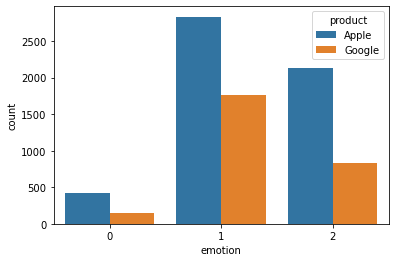

In [19]:
import seaborn as sns
sns.countplot(df_1['emotion'], hue=df_1['product'])

## TRAIN TEST SPLIT

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_1.drop('emotion',axis=1), df_1['emotion'], random_state=42)

## Addressing Class Imbalance using imblearn

In [21]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [22]:
ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# print('Old shape of y:' + str(Counter(y)))
# print('New shape of y:' + str(Counter(y_ros)))

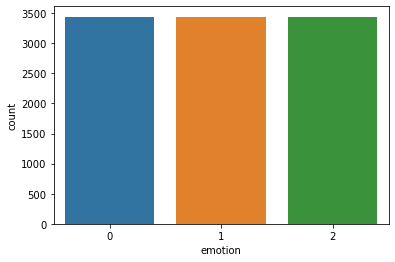

In [23]:
sns.countplot(y_train_ros);

In [24]:
X_train_ros['product'].value_counts()

Apple     7178
Google    3145
Name: product, dtype: int64

## Modeling

In [25]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=500, stop_words=stopwords_list, tokenizer=stem_and_tokenize, strip_accents='ascii')

# Fit the vectorizer on X_train["text"] and transform it
X_train_ros_vectorized = tfidf.fit_transform(X_train_ros["tweet_text"])
# Visually inspect the vectorized data
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_ros_vectorized, columns=tfidf.get_feature_names())

In [26]:
# transforming the test data
X_test_vectorized = tfidf.transform(X_test['tweet_text'])
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

## Decision Tree

In [27]:
# function to evaluate the model
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

In [28]:
def evaluation_metrics(y_true, y_pred):
    conf_mtx = confusion_matrix(y_true, y_pred)
    neutral_1 = conf_mtx[1,1] / sum(conf_mtx[1,:])
    neutral_2 = conf_mtx[1,1] / sum(conf_mtx[:,1])
    negative_1 = conf_mtx[0,0] / sum(conf_mtx[0,:])
    negative_2 = conf_mtx[0,0] / sum(conf_mtx[:,0])
    print(f'True Neutral prediction accuracy: {neutral_1}')
    print(f'Predicted Neutral prediction accuracy: {neutral_2}')
    print(f'True Negative prediction accuracy: {negative_1}')
    print(f'Predicted Negative prediction accuracy: {negative_2}')

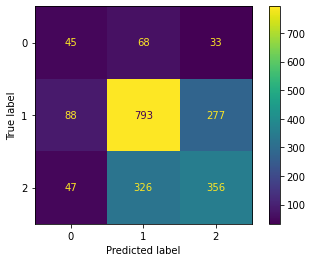

In [29]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train_df, y_train_ros)

plot_confusion_matrix(tree,X_test_df,y_test);

In [30]:
tree_predictions = tree.predict(X_test_df)
evaluation_metrics(y_test, tree_predictions)

True Neutral prediction accuracy: 0.6848013816925734
Predicted Neutral prediction accuracy: 0.6680707666385847
True Negative prediction accuracy: 0.3082191780821918
Predicted Negative prediction accuracy: 0.25


## Logistic Regression

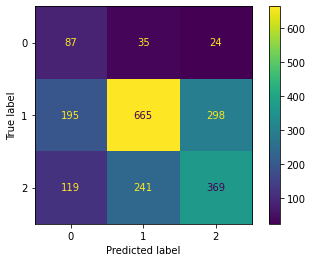

In [31]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# no parameters
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_df, y_train_ros)
plot_confusion_matrix(log_reg,X_test_df,y_test);

In [32]:
logistic_preds = log_reg.predict(X_test_df)
evaluation_metrics(y_test, logistic_preds)

True Neutral prediction accuracy: 0.57426597582038
Predicted Neutral prediction accuracy: 0.7066950053134963
True Negative prediction accuracy: 0.5958904109589042
Predicted Negative prediction accuracy: 0.2169576059850374


## Multinomial NB

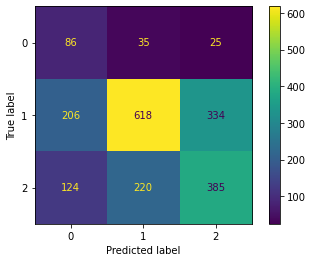

In [33]:
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB()
naive.fit(X_train_df,y_train_ros)
plot_confusion_matrix(naive,X_test_df,y_test);

In [34]:
naive_preds = naive.predict(X_test_df)
evaluation_metrics(y_test, naive_preds)

True Neutral prediction accuracy: 0.533678756476684
Predicted Neutral prediction accuracy: 0.7079037800687286
True Negative prediction accuracy: 0.589041095890411
Predicted Negative prediction accuracy: 0.20673076923076922


# Conclusion

# Future Research

# Citations